In [1]:
%load_ext autoreload
%autoreload 2

# Model design
import agentpy as ap
import networkx as nx
import random
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import IPython

from EnergyShedModel import EnergyShedModel

random.seed(1)

POP_SIZE = 400
NUM_NEIGHBORS = 6
NUM_STEPS = 100

In [2]:
parameters = {"population": POP_SIZE, "number_of_neighbors": NUM_NEIGHBORS, "network_randomness": 0.5, "steps": NUM_STEPS, "grid_size": (20, 20)}

model = EnergyShedModel(parameters)
results = model.run()

Completed: 100 steps
Run time: 0:00:00.385419
Simulation finished


In [108]:
results.reporters

,seed,Per household energy transfer,Peak energy production,Total Energy Production,Total Energy Transfer
0,272996653310673477252411125948039410165,"[1.6554147735632672, 0.6906229248484284, 2.316...",5575.67106,507158.812248,7810.367394


In [109]:
results.variables.EnergyShedModel

,none,buy,sell,energy_production,energy_transfer,weather
t,,,,,,
0,1.000,0.000,0.000,5000.000000,0.000000,Cloudy
1,0.438,0.060,0.502,5435.487560,137.998642,Sunny
2,0.552,0.396,0.052,4494.263800,-28.693860,Cloudy
3,0.432,0.518,0.050,4530.252625,21.329983,Cloudy
4,0.430,0.530,0.040,4542.014518,58.984837,Cloudy
...,...,...,...,...,...,...
96,0.566,0.368,0.066,4470.069216,-93.880204,Cloudy
97,0.470,0.496,0.034,4499.599130,9.783803,Cloudy
98,0.466,0.490,0.044,4611.178183,60.147846,Cloudy


      none    buy   sell  energy_production  energy_transfer weather
t                                                                   
0    1.000  0.000  0.000        5000.000000         0.000000  Cloudy
1    0.438  0.060  0.502        5435.487560       137.998642   Sunny
2    0.552  0.396  0.052        4494.263800       -28.693860  Cloudy
3    0.432  0.518  0.050        4530.252625        21.329983  Cloudy
4    0.430  0.530  0.040        4542.014518        58.984837  Cloudy
..     ...    ...    ...                ...              ...     ...
96   0.566  0.368  0.066        4470.069216       -93.880204  Cloudy
97   0.470  0.496  0.034        4499.599130         9.783803  Cloudy
98   0.466  0.490  0.044        4611.178183        60.147846  Cloudy
99   0.578  0.078  0.344        5461.467068       156.334025   Sunny
100  0.434  0.056  0.510        5455.700863       204.699114   Sunny

[101 rows x 6 columns]


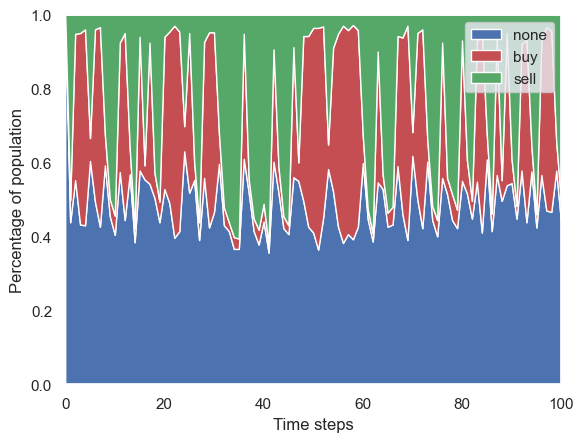

In [110]:
color_map = {"labels": ["none", "buy", "sell"], "colors": ["b", "r", "g"]}

def EnergyShed_stackplot(data, ax):
    """Stackplot of people's condition over time."""
    x = data.index.get_level_values("t")
    y = [data[var] for var in ["none", "buy", "sell"]]

    sns.set()
    ax.stackplot(x, y, **color_map)

    ax.legend()
    ax.set_xlim(0, max(1, len(x) - 1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")


fig, ax = plt.subplots()
EnergyShed_stackplot(results.variables.EnergyShedModel, ax)

In [111]:
def animation_plot(m, axs):
    ax1, ax2 = axs
    ax1.set_title("EnergyShed spread")

    # Plot stackplot on first axis
    EnergyShed_stackplot(m.output.variables.EnergyShedModel, ax1)

    # Plot network on second axis
    color_dict = {0: "b", -1: "r", 1: "g"}
    colors = [color_dict[c] for c in m.agents.status]
    nx.draw_circular(m.network.graph, node_color=colors, node_size=50, ax=ax2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Prepare figure
parameters["population"] = 50  # Lower population for better visibility
animation = ap.animate(EnergyShedModel(parameters), fig, axs, animation_plot)
IPython.display.HTML(animation.to_jshtml())

   none  buy  sell  energy_production  energy_transfer weather
t                                                             
0   1.0  0.0   0.0                500                0  Cloudy


AttributeError: Grid (Obj 51) has no attribute 'graph'.

In [4]:
def animation_plot(model, ax):
    group_grid = model.network.attr_grid('status')
    color_dict = {0: "b", -1: "r", 1: "g"}
    cmap = colors.ListedColormap([color_dict[key] for key in color_dict])  
    ap.gridplot(group_grid, cmap=cmap, ax=ax)
    ax.set_title(f"Energyshed model \n Time-step: {model.t}, "
                 f"Energy Transfer: {model.get_cost()},"
                 f"Weather: {model.get_weather()}")
    
fig, ax = plt.subplots()
model = EnergyShedModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml())

# Experiments

In [25]:
parameters = {
    "population": ap.IntRange(100, 1000),
    "number_of_neighbors": 4,
    "network_randomness": ap.Range(0.0, 1.0),
}

sample = ap.Sample(parameters, n=128, method="saltelli", calc_second_order=False)

In [ ]:
exp = ap.Experiment(EnergyShedModel, sample, iterations=10)
results = exp.run()

Scheduled runs: 5120


KeyboardInterrupt: 

In [ ]:
results.save()

In [ ]:
results

In [ ]:
results.reporters.hist();

In [ ]:
# Sensitivity Analysis

In [ ]:
results.calc_sobol()

In [ ]:
def plot_sobol(results):
    """Bar plot of Sobol sensitivity indices."""

    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by="reporter")
    si_conf_list = results.sensitivity.sobol_conf.groupby(by="reporter")

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        si = si.droplevel("reporter")
        err = err.droplevel("reporter")
        si.plot.barh(xerr=err, title=key, ax=ax, capsize=3)
        ax.set_xlim(0)

    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[])
    axs[1].tick_params(left=False)
    plt.tight_layout()


plot_sobol(results)

In [ ]:
def plot_sensitivity(results):
    """Show average simulation results for different parameter values."""

    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j]  # Flatten list

    data = results.arrange_reporters().astype("float")
    params = results.parameters.sample.keys()

    for x, ax in zip(params, axs):
        for y in results.reporters.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, x_bins=15, fit_reg=False, label=y)
        ax.set_ylim(0, 1)
        ax.set_ylabel("")
        ax.legend()

    plt.tight_layout()


plot_sensitivity(results)